In [2]:
#Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import class_weight
from PIL import Image
import os
import xml.etree.ElementTree as ET
from scipy.io import loadmat
import pandas as pd
import seaborn as sns
pd.set_option('display.max_rows', None)
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator


2023-10-26 11:38:56.871930: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 11:38:59.926141: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
#Reading the meta data file
mat_train = loadmat('stanford car data/devkit/cars_train_annos.mat')
mat_test = loadmat('stanford car data/devkit/cars_test_annos.mat')
meta = loadmat('stanford car data/devkit/cars_meta.mat')

In [3]:
#saving the names of the vehicle label
labels = list()
for l in meta['class_names'][0]:
    labels.append(l[0])
print(f'Number of classes are {len(labels)}')

Number of classes are 196


In [4]:
train = list()
for example in mat_train['annotations'][0]:
    label = labels[example[-2][0][0]-1]
    image = example[-1][0]
    bbox_x1 = example[0][0][0]
    bbox_x2 = example[1][0][0]
    bbox_y1 = example[2][0][0]
    bbox_y2 = example[3][0][0]
    train.append((image,bbox_x1, bbox_x2, bbox_y1, bbox_y2, label))

In [5]:
test = list()
for example in mat_test['annotations'][0]:
    image = example[-1][0]
    test.append(image)

validation_size = int(len(train) * 0.10)
test_size = int(len(train) * 0.20)

validation = train[:validation_size].copy()
np.random.shuffle(validation)
train = train[validation_size:]

test = train[:test_size].copy()
np.random.shuffle(test)
train = train[test_size:]

In [6]:
test_path = "stanford car data/cars_test/cars_test/"
train_path = "stanford car data/cars_train/cars_train/"
org_path = "stanford car data/cars_train/cars_train/"
org_path_test = "stanford car data/cars_test/cars_test/"

In [ ]:
with open('stanford car data/cars_data1.csv', 'w+') as f:
    header = "TYPE,TRAIN_PATH,ORG_PATH,BBOX_X1,BBOX_X2,BBOX_Y1,BBOX_Y2,LABEL,IMAGE\n"
    f.write(header)
    [f.write('TRAIN,%s,%s%s,%s,%s,%s,%s,%s,%s\n' %(train_path, org_path, img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab,img)) for img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab in train]
    [f.write('VALIDATION,%s,%s%s,%s,%s,%s,%s,%s,%s\n' %(train_path, org_path, img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab,img)) for img, bbox_x1, bbox_x2, bbox_y1, bbox_y2, lab in validation]
    [f.write('TEST,%s,%s,%s\n' %(test_path, org_path_test, img)) for img,_,_,_,_,_ in test]# encoding:utf8

In [3]:

data_met = pd.read_csv('stanford car data/cars_data1.csv')

In [4]:
# creating training data set
train_data_met = data_met.dropna()
train_data_met.head(5)

,TYPE,TRAIN_PATH,ORG_PATH,BBOX_X1,BBOX_X2,BBOX_Y1,BBOX_Y2,LABEL,IMAGE
0,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02443.jpg,74,62.0,617.0,411.0,HUMMER H3T Crew Cab 2010,02443.jpg
1,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02444.jpg,70,60.0,737.0,541.0,Ford F-150 Regular Cab 2012,02444.jpg
2,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02445.jpg,30,99.0,743.0,427.0,Buick Rainier SUV 2007,02445.jpg
3,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02446.jpg,60,126.0,839.0,578.0,Lamborghini Diablo Coupe 2001,02446.jpg
4,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02447.jpg,64,58.0,341.0,177.0,Ram C/V Cargo Van Minivan 2012,02447.jpg


In [5]:
#removing '/' before creating folder as it is a problem to give paths
train_data_met['LABEL'] = train_data_met['LABEL'].str.replace('/','')
brand = train_data_met['LABEL'].unique()
len(brand)
print(brand)

['HUMMER H3T Crew Cab 2010' 'Ford F-150 Regular Cab 2012'
 'Buick Rainier SUV 2007' 'Lamborghini Diablo Coupe 2001'
 'Ram CV Cargo Van Minivan 2012' 'Dodge Dakota Club Cab 2007'
 'Honda Odyssey Minivan 2012' 'Buick Verano Sedan 2012'
 'BMW 1 Series Convertible 2012'
 'Bentley Continental Flying Spur Sedan 2007'
 'Dodge Ram Pickup 3500 Crew Cab 2010' 'GMC Terrain SUV 2012'
 'Audi TT RS Coupe 2012' 'Acura TSX Sedan 2012'
 'Chevrolet Camaro Convertible 2012' 'Chevrolet Monte Carlo Coupe 2007'
 'Volkswagen Golf Hatchback 1991' 'Jeep Wrangler SUV 2012'
 'Hyundai Genesis Sedan 2012' 'Audi A5 Coupe 2012'
 'BMW 3 Series Sedan 2012' 'GMC Canyon Extended Cab 2012'
 'Hyundai Elantra Touring Hatchback 2012' 'BMW M5 Sedan 2010'
 'Hyundai Veloster Hatchback 2012' 'Lamborghini Aventador Coupe 2012'
 'Dodge Charger Sedan 2012' 'Chrysler Crossfire Convertible 2008'
 'Audi TTS Coupe 2012' 'Isuzu Ascender SUV 2008' 'Spyker C8 Coupe 2009'
 'Audi S5 Convertible 2012' 'Dodge Caliber Wagon 2012' 'BMW M3 Coup

/tmp/ipykernel_2917/1995083760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_met['LABEL'] = train_data_met['LABEL'].str.replace('/','')


In [6]:

v_type = []
for name in train_data_met['LABEL']:
    name_split = name.split(' ')
    if 'Sedan' in name_split or 'SS' in name_split or 'SRT' in name_split or 'SRT8' in name_split or 'SRT-8' in name_split or 'Corvette' in name_split or name ==  'Acura TL Type-S 2008' or name == 'Buick Regal GS 2012':
        v_type.append('Sedan')
    elif 'Coupe' in name_split:
        v_type.append('Coupe')
    elif 'Convertible' in name_split:
        v_type.append('Convertible')
    elif 'Van' in name_split or 'Minivan' in name_split:
        v_type.append('Van')
    elif 'SUV' in name_split:
        v_type.append('SUV')
    elif 'Hatchback' in name_split or ('FIAT' in name_split and '500' in name_split):
        v_type.append('Hatchback')
    elif 'Crew' in name_split or 'Cab' in name_split or 'SuperCab' in name_split:
        v_type.append('CrewCab')
    elif 'Wagon' in name_split:
        v_type.append('Wagon')
    elif name == 'Acura Integra Type R 2001' or name =='Jaguar XK XKR 2012' or name =='Lamborghini Gallardo LP 570-4 Superleggera 2012':
        v_type.append('sports')
    else:
        v_type.append('other')


In [7]:
train_data_met['v_type']=v_type

/tmp/ipykernel_2917/338411027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_met['v_type']=v_type


In [8]:
train_data_met.head(5)

,TYPE,TRAIN_PATH,ORG_PATH,BBOX_X1,BBOX_X2,BBOX_Y1,BBOX_Y2,LABEL,IMAGE,v_type
0,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02443.jpg,74,62.0,617.0,411.0,HUMMER H3T Crew Cab 2010,02443.jpg,CrewCab
1,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02444.jpg,70,60.0,737.0,541.0,Ford F-150 Regular Cab 2012,02444.jpg,CrewCab
2,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02445.jpg,30,99.0,743.0,427.0,Buick Rainier SUV 2007,02445.jpg,SUV
3,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02446.jpg,60,126.0,839.0,578.0,Lamborghini Diablo Coupe 2001,02446.jpg,Coupe
4,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02447.jpg,64,58.0,341.0,177.0,Ram CV Cargo Van Minivan 2012,02447.jpg,Van


In [16]:
type_dist = train_data_met['v_type'].value_counts().to_frame()
type_dist.sort_values('count')

,count
v_type,
sports,100
Wagon,206
Van,428
Hatchback,475
CrewCab,601
Convertible,776
Coupe,892
SUV,1130
Sedan,1908


In [9]:
new_classes = list(set(v_type))
new_classes

['Sedan',
 'CrewCab',
 'Wagon',
 'Convertible',
 'Van',
 'SUV',
 'Hatchback',
 'Coupe',
 'sports']

<Axes: xlabel='count', ylabel='v_type'>

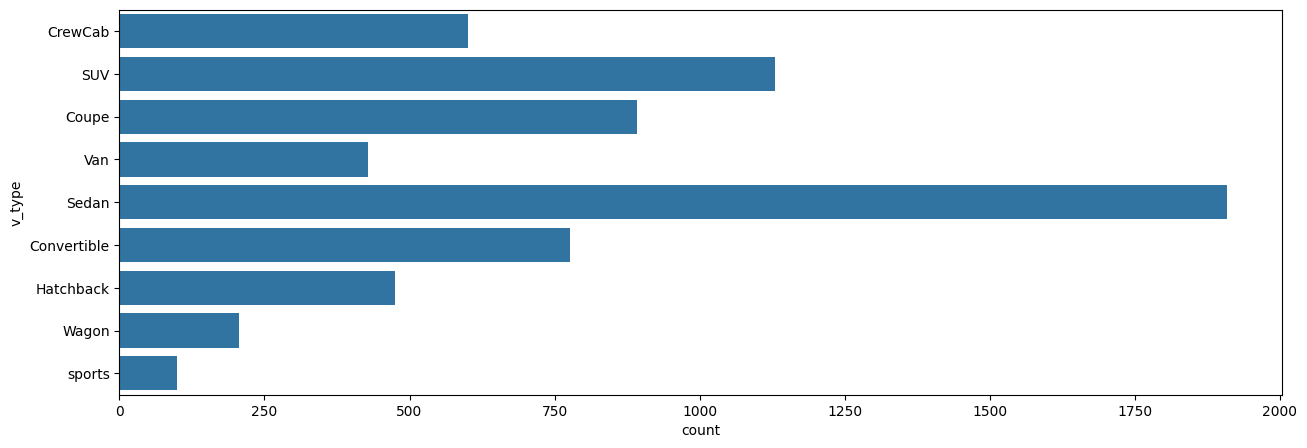

In [10]:
plt.figure(figsize=(15,5))
sns.countplot(y = 'v_type',data = train_data_met)

In [ ]:

#creating a new folder to store cropped car images
os.mkdir('stanford car data/new_data')
for new_classes in new_classes:
    os.mkdir('stanford car data/new_data/' + new_classes)

In [22]:
print('Created {} folders to store cropped images of the different types.'.format(len(os.listdir('stanford car data/new_data'))))

Created 9 folders to store cropped images of the different types.


In [24]:
train_data_met.head(1)

,TYPE,TRAIN_PATH,ORG_PATH,BBOX_X1,BBOX_X2,BBOX_Y1,BBOX_Y2,LABEL,IMAGE,v_type
0,TRAIN,stanford car data/cars_train/cars_train/,stanford car data/cars_train/cars_train/02443.jpg,74,62.0,617.0,411.0,HUMMER H3T Crew Cab 2010,02443.jpg,CrewCab


In [27]:
for i in range(0,6516):
    a =train_data_met['ORG_PATH'][i]
    xmin = int(train_data_met['BBOX_X1'][i]) 
    ymin = int(train_data_met['BBOX_X2'][i])
    xmax = int(train_data_met['BBOX_Y1'][i])
    ymax = int(train_data_met['BBOX_Y2'][i])
    print(i,a,xmin,xmax,ymin,ymax)
    img = Image.open(a)
    img = img.crop((xmin, ymin, xmax, ymax))
    img = img.convert('RGB')
    img = img.resize((224, 224))
    filename = train_data_met['IMAGE'][i]
    img.save('stanford car data/new_data/' + train_data_met['v_type'][i] + '/'+filename)

0 stanford car data/cars_train/cars_train/02443.jpg 74 617 62 411
1 stanford car data/cars_train/cars_train/02444.jpg 70 737 60 541
2 stanford car data/cars_train/cars_train/02445.jpg 30 743 99 427
3 stanford car data/cars_train/cars_train/02446.jpg 60 839 126 578
4 stanford car data/cars_train/cars_train/02447.jpg 64 341 58 177
5 stanford car data/cars_train/cars_train/02448.jpg 3 1017 226 621
6 stanford car data/cars_train/cars_train/02449.jpg 61 595 150 378
7 stanford car data/cars_train/cars_train/02450.jpg 51 595 99 382
8 stanford car data/cars_train/cars_train/02451.jpg 29 269 11 159
9 stanford car data/cars_train/cars_train/02452.jpg 20 249 44 161
10 stanford car data/cars_train/cars_train/02453.jpg 24 450 61 306
11 stanford car data/cars_train/cars_train/02454.jpg 50 605 167 392
12 stanford car data/cars_train/cars_train/02455.jpg 79 563 97 353
13 stanford car data/cars_train/cars_train/02456.jpg 40 224 38 155
14 stanford car data/cars_train/cars_train/02457.jpg 126 885 227 551

In [11]:
train_directory = "stanford car data/new_data"
#Data Augmentation and train-val split
#keras_preprocessing.image  ImageDataGenerator is used to generate tensor of image with realtime data augmentation.
#rescale helps to reduce the parameter
#shear range determines the maximum extent to which an object or an image can be distorted along a particular axis.
#zoom range is the range of random zoom
sd_gen = ImageDataGenerator(
    rescale = 1./255,
    shear_range=0.1,
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=10,
    horizontal_flip=True,
    validation_split=0.2,
)

In [12]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory
#Loading train data
train_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Loading val data
val_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 5215 images belonging to 9 classes.
Found 1301 images belonging to 9 classes.


In [41]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_gen.classes),y = train_gen.classes)

In [40]:
#class_weight=class_weights) 

array([0, 0, 0, ..., 8, 8, 8], dtype=int32)

Found 5215 images belonging to 9 classes.


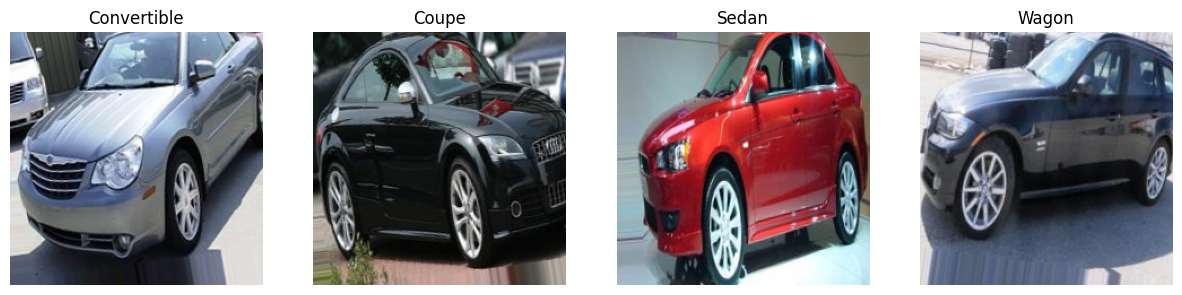

In [14]:
rand_gen = sd_gen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=1,
    class_mode='categorical',
    subset='training'
)

plt.figure(figsize=(15,10))
for i in range(4):
    rand_img = next(rand_gen)
    name = list(rand_gen.class_indices.keys())[list(rand_gen.class_indices.values()).index(np.argmax(rand_img[1]))]
    plt.subplot(1,4,i+1)
    plt.title(name)
    plt.imshow(rand_img[0].reshape(224, 224, 3))
    plt.axis('off')

In [43]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.models import Sequential

In [45]:
base_model_rsn0 = keras.applications.ResNet50V2(
    weights = 'imagenet',
    input_shape=(224, 224, 3),
    include_top=False)
x = keras.layers.Flatten()(base_model_rsn0.output)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x) #half the dense
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x) #increased the drop out

out = keras.layers.Dense(9, activation='softmax')(x)

base_model_rsn0.trainable = False
for layer in base_model_rsn0.layers:
    layer.trainable = False

2023-10-25 19:25:12.234719: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [46]:
model_rsn0 = keras.Model(base_model_rsn0.input, out)

#Compiling the model
model_rsn0.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)

In [47]:
#Setting checkpoints to save epochs with best validation accuracy
checkpoint_path = "training/cp-best.ckpt0"
checkpoint_dir = os.path.dirname(checkpoint_path)
callbacks = [ keras.callbacks.ModelCheckpoint(checkpoint_dir, monitor='val_accuracy', verbose=1, save_weights_only = True, save_best_only = True, mode='max')]

In [53]:
class_weights

array([0.93308284, 0.81154684, 1.2046662 , 1.5248538 , 0.64097837,
       0.37946591, 1.6893424 , 3.51178451, 7.24305556])

In [54]:
history_rsn5 = model_rsn0.fit_generator(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=80,
    validation_steps=8,  
    epochs=30,
    verbose=1,
    callbacks = callbacks,
    class_weight={0:0.93308284,1:0.81154684,2:1.2046662,3:1.5248538,4:0.64097837,5:0.37946591,6:1.6893424,7:3.51178451,8:7.24305556})

/tmp/ipykernel_3519/2449412608.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rsn5 = model_rsn0.fit_generator(


Epoch 1/30
80/80 [==============================] - ETA: 0s - loss: 3.8928 - accuracy: 0.3181
Epoch 1: val_accuracy improved from -inf to 0.46875, saving model to training
80/80 [==============================] - 81s 966ms/step - loss: 3.8928 - accuracy: 0.3181 - val_loss: 8.4654 - val_accuracy: 0.4688
Epoch 2/30
80/80 [==============================] - ETA: 0s - loss: 3.1004 - accuracy: 0.3871
Epoch 2: val_accuracy did not improve from 0.46875
80/80 [==============================] - 72s 900ms/step - loss: 3.1004 - accuracy: 0.3871 - val_loss: 4.5872 - val_accuracy: 0.3828
Epoch 3/30
80/80 [==============================] - ETA: 0s - loss: 2.6886 - accuracy: 0.3812
Epoch 3: val_accuracy did not improve from 0.46875
80/80 [==============================] - 72s 899ms/step - loss: 2.6886 - accuracy: 0.3812 - val_loss: 3.5500 - val_accuracy: 0.3359
Epoch 4/30
80/80 [==============================] - ETA: 0s - loss: 1.8750 - accuracy: 0.4392
Epoch 4: val_accuracy improved from 0.46875 to 0

In [55]:
model_rsn0.save("model lib/final_rldep=30_lr=0.1C9.model", save_format="h5")

/home/azureuser/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


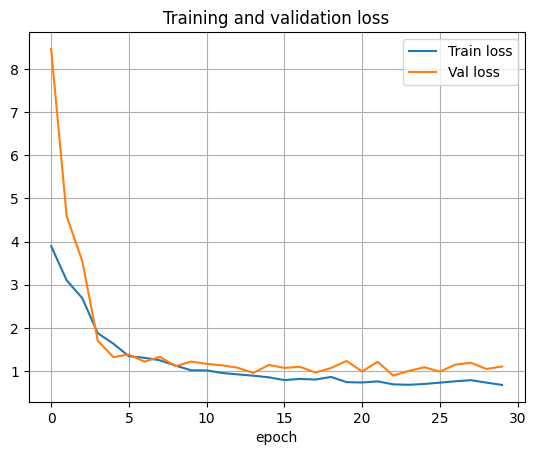

In [57]:
fig = plt.figure()

plt.plot(history_rsn5.history['loss'], label='Train loss')
plt.plot(history_rsn5.history['val_loss'], label='Val loss')
plt.legend(loc=0)
plt.title('Training and validation loss')
plt.grid(True)
plt.xlabel('epoch')
plt.show()

In [58]:
loss, acc = model_rsn0.evaluate(val_gen) #evaluating ResNet50V2 model on new validation set
print(f"val_loss: {loss}, val_acc:{round(acc*100,2)}%")

41/41 [==============================] - 17s 399ms/step - loss: 1.0130 - accuracy: 0.6434
val_loss: 1.012963056564331, val_acc:64.34%


In [59]:
data_met_T = pd.read_csv('stanford car data/cars_data_test.csv')

In [60]:
#removing '/' before creating folder as it is a problem to give paths
data_met_T['LABEL'] = data_met_T['LABEL'].str.replace('/','')
brand_t = data_met_T['LABEL'].unique()
len(brand_t)

196

In [64]:
new_classes

['SUV',
 'Convertible',
 'Coupe',
 'Sedan',
 'Hatchback',
 'sports',
 'Van',
 'Wagon',
 'CrewCab']

In [65]:
#creating a new folder to store cropped car images
os.mkdir('stanford car data/test_data_new')
for new_classes in new_classes:
    os.mkdir('stanford car data/test_data_new/' + new_classes)
print('Created {} folders to store test images of the different types.'.format(len(os.listdir('stanford car data/test_data_new'))))

Created 9 folders to store test images of the different types.


In [69]:
v_type1 = []
for name in data_met_T['LABEL']:
    name_split = name.split(' ')
    if 'Sedan' in name_split or 'SS' in name_split or 'SRT' in name_split or 'SRT8' in name_split or 'SRT-8' in name_split or 'Corvette' in name_split or name ==  'Acura TL Type-S 2008' or name == 'Buick Regal GS 2012':
        v_type1.append('Sedan')
    elif 'Coupe' in name_split:
        v_type1.append('Coupe')
    elif 'Convertible' in name_split:
        v_type1.append('Convertible')
    elif 'Van' in name_split or 'Minivan' in name_split:
        v_type1.append('Van')
    elif 'SUV' in name_split:
        v_type1.append('SUV')
    elif 'Hatchback' in name_split or ('FIAT' in name_split and '500' in name_split):
        v_type1.append('Hatchback')
    elif 'Crew' in name_split or 'Cab' in name_split or 'SuperCab' in name_split:
        v_type1.append('CrewCab')
    elif 'Wagon' in name_split:
        v_type1.append('Wagon')
    elif name == 'Acura Integra Type R 2001' or name =='Jaguar XK XKR 2012' or name =='Lamborghini Gallardo LP 570-4 Superleggera 2012':
        v_type1.append('sports')
    else:
        v_type1.append('other')

In [70]:
data_met_T['v_type']=v_type1

In [71]:
data_met_T.head(1)

,TYPE,ORG_PATH,PATH,BBOX_X1,BBOX_X2,BBOX_Y1,BBOX_Y2,LABEL,IMAGE,v_type
0,TEST,stanford car data/cars_test/cars_test/,stanford car data/cars_train/cars_train/01823.jpg,82,109,450,300,Chrysler PT Cruiser Convertible 2008,01823.jpg,Convertible


In [72]:
for i in range(0,1627):
    a =data_met_T['PATH'][i]
    # xmin = int(train_data_met['xmin'][i])
    # ymin = int(train_data_met['ymin'][i])
    # xmax = int(train_data_met['xmax'][i])
    # ymax = int(train_data_met['ymax'][i])
    print(i,a)
    img = Image.open(a)
    #img = img.crop((xmin, ymin, xmax, ymax))
    img = img.convert('RGB')
    img = img.resize((224, 224))
    filename = train_data_met['IMAGE'][i]
    img.save('stanford car data/test_data_new/' + data_met_T['v_type'][i] + '/'+filename)

0 stanford car data/cars_train/cars_train/01823.jpg
1 stanford car data/cars_train/cars_train/01441.jpg
2 stanford car data/cars_train/cars_train/01005.jpg
3 stanford car data/cars_train/cars_train/02351.jpg
4 stanford car data/cars_train/cars_train/02309.jpg
5 stanford car data/cars_train/cars_train/02040.jpg
6 stanford car data/cars_train/cars_train/01071.jpg
7 stanford car data/cars_train/cars_train/00943.jpg
8 stanford car data/cars_train/cars_train/01186.jpg
9 stanford car data/cars_train/cars_train/01903.jpg
10 stanford car data/cars_train/cars_train/01898.jpg
11 stanford car data/cars_train/cars_train/02280.jpg
12 stanford car data/cars_train/cars_train/00926.jpg
13 stanford car data/cars_train/cars_train/02102.jpg
14 stanford car data/cars_train/cars_train/01813.jpg
15 stanford car data/cars_train/cars_train/02066.jpg
16 stanford car data/cars_train/cars_train/01075.jpg
17 stanford car data/cars_train/cars_train/01820.jpg
18 stanford car data/cars_train/cars_train/01493.jpg
19 

In [73]:
test_directory = "stanford car data/test_data_new/"
sd_gen_t = ImageDataGenerator(
    rescale = 1./255,
)

test_gen = sd_gen_t.flow_from_directory(
    test_directory,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1627 images belonging to 9 classes.


In [74]:
loss_test, acc_test = model_rsn0.evaluate(test_gen) #evaluating ResNet50V2 model on fresh test set
print(f"test_loss: {loss_test}, test_acc:{round(acc_test*100,2)}%")

51/51 [==============================] - 20s 397ms/step - loss: 1.4058 - accuracy: 0.5470
test_loss: 1.405778408050537, test_acc:54.7%


In [75]:
# Get the class labels
class_labels = list(test_gen.class_indices.keys())

# Retrieve the filenames, true labels, and predicted labels
filenames = test_gen.filenames
labels = test_gen.labels

# Predict labels for the test set
predictions = model_rsn0.predict(test_gen)
predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the class with the highest probability

# Iterate over the filenames, true labels, and predicted labels
for filename, true_label, predicted_label in zip(filenames, labels, predicted_labels):
    # Retrieve the corresponding class labels
    true_class_label = class_labels[true_label]
    predicted_class_label = class_labels[predicted_label]

    # Print the filename, true label, and predicted label
    print(f"Filename: {filename}, True Label: {true_class_label}, Predicted Label: {predicted_class_label}")

51/51 [==============================] - 21s 394ms/step
Filename: Convertible/02443.jpg, True Label: Convertible, Predicted Label: Coupe
Filename: Convertible/02451.jpg, True Label: Convertible, Predicted Label: Convertible
Filename: Convertible/02464.jpg, True Label: Convertible, Predicted Label: Hatchback
Filename: Convertible/02468.jpg, True Label: Convertible, Predicted Label: Convertible
Filename: Convertible/02485.jpg, True Label: Convertible, Predicted Label: Convertible
Filename: Convertible/02514.jpg, True Label: Convertible, Predicted Label: Convertible
Filename: Convertible/02537.jpg, True Label: Convertible, Predicted Label: Convertible
Filename: Convertible/02544.jpg, True Label: Convertible, Predicted Label: CrewCab
Filename: Convertible/02546.jpg, True Label: Convertible, Predicted Label: Sedan
Filename: Convertible/02558.jpg, True Label: Convertible, Predicted Label: Convertible
Filename: Convertible/02563.jpg, True Label: Convertible, Predicted Label: Convertible
Filen